In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import os
import sys
import random



In [2]:
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)
random.seed(random_state)
os.environ['PYTHONHASHSEED'] = str(random_state)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

In [3]:
module_path = os.path.abspath(os.path.join('..', 'modules'))
if module_path not in sys.path:
    sys.path.append(module_path)
from preprocessing_functions import preprocessing_for_lstm, preprocessing_test

In [4]:
scaled_train_df = pd.read_pickle('../items/scaled_train_df_001.pkl')
scaled_test_df = pd.read_pickle('../items/scaled_test_df_001.pkl')
train_001 = pd.read_pickle('../items/train_001.pkl')
rul_001 = pd.read_pickle('../items/rul_001.pkl')

In [5]:
def asymmetric_loss(RUL_true, RUL_predicted, a1=10, a2=13):

    diff = tf.subtract(RUL_true,RUL_predicted)
    loss = tf.reduce_sum(tf.where(diff < 0, tf.exp(-diff/a1)-1, tf.exp(diff/a2)-1), axis=0)
    return loss

In [6]:
window_size = 10
ceil_rul=float(150)
X, y = preprocessing_for_lstm(scaled_train_df, "engine_num", train_001['rul'], window_size, ["engine_num"],max_rul=ceil_rul, shift = 1)
shuffled_index = np.random.permutation(len(X))
X, y = X[shuffled_index], y[shuffled_index]

In [7]:
test_processed = preprocessing_test(scaled_test_df, "engine_num", ["engine_num"], window_size=window_size)

In [8]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("test_processed shape: ", test_processed.shape)
print("RUL_FD001 shape: ", rul_001.shape)

X shape:  (19731, 10, 15)
y shape:  (19731,)
test_processed shape:  (100, 10, 15)
RUL_FD001 shape:  (100, 1)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = random_state)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (15784, 10, 15)
X_test shape:  (3947, 10, 15)
y_train shape:  (15784,)
y_test shape:  (3947,)


In [10]:
initializer = tf.initializers.GlorotNormal(seed=random_state)

model = Sequential([
    layers.LSTM(128, input_shape = (X.shape[1], X.shape[2]), return_sequences=True, activation = "tanh", bias_initializer="ones", kernel_initializer=initializer,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
               ),        
    layers.LSTM(64, activation = "tanh", bias_initializer="ones", kernel_initializer=initializer,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3),
               ),
    layers.Dropout(0.5, seed=random_state),
    layers.Dense(32, activation = "relu", kernel_initializer=initializer,
                ),
    layers.Dense(8, activation = "relu", kernel_initializer=initializer,
                ),
    layers.Dense(1)
])

model.compile(loss = asymmetric_loss, metrics=["mse"], optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))

In [11]:
history = model.fit(X_train, y_train, epochs = 30,
                    validation_data = (X_test, y_test),
                    shuffle = False,
                    batch_size = 96, verbose = 2)
loss, mse = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MSE: {mse}")

Epoch 1/30
165/165 - 15s - loss: 885773.9375 - mse: 7396.0479 - val_loss: 60541.3477 - val_mse: 4179.0933 - 15s/epoch - 89ms/step
Epoch 2/30
165/165 - 6s - loss: 32527.5293 - mse: 3301.3521 - val_loss: 10214.0820 - val_mse: 2227.9312 - 6s/epoch - 38ms/step
Epoch 3/30
165/165 - 6s - loss: 8611.3076 - mse: 1921.0212 - val_loss: 3744.7102 - val_mse: 1464.0541 - 6s/epoch - 38ms/step
Epoch 4/30
165/165 - 7s - loss: 4931.3755 - mse: 1463.8408 - val_loss: 2418.8872 - val_mse: 1164.5750 - 7s/epoch - 40ms/step
Epoch 5/30
165/165 - 6s - loss: 3642.2505 - mse: 1240.2327 - val_loss: 2084.3943 - val_mse: 1073.4543 - 6s/epoch - 34ms/step
Epoch 6/30
165/165 - 5s - loss: 3303.3975 - mse: 1127.2919 - val_loss: 1914.7822 - val_mse: 999.9638 - 5s/epoch - 33ms/step
Epoch 7/30
165/165 - 5s - loss: 2967.5762 - mse: 1057.2328 - val_loss: 1530.9387 - val_mse: 880.2430 - 5s/epoch - 33ms/step
Epoch 8/30
165/165 - 5s - loss: 2739.5125 - mse: 997.4833 - val_loss: 1447.2906 - val_mse: 814.0106 - 5s/epoch - 33ms/st

In [12]:
RUL_predicted = model.predict(test_processed)

MSE = mean_squared_error(rul_001, RUL_predicted)
MAE = np.abs(rul_001 - RUL_predicted).values.mean()
std_AE = np.abs(rul_001 - RUL_predicted).values.std()
R2 = r2_score(rul_001, RUL_predicted)
print("MSE: ", MSE.round(2))
print("RMSE: ", np.sqrt(MSE).round(2))
print("MAE: ", MAE.round(2))
print("R² Score: ", R2.round(2))
print("assymetric_loss: ", asymmetric_loss(rul_001, RUL_predicted).numpy())

4/4 [==============================] - 1s 6ms/step
MSE:  337.83
RMSE:  18.38
MAE:  13.08
R² Score:  0.8
assymetric_loss:  [627.35010679]


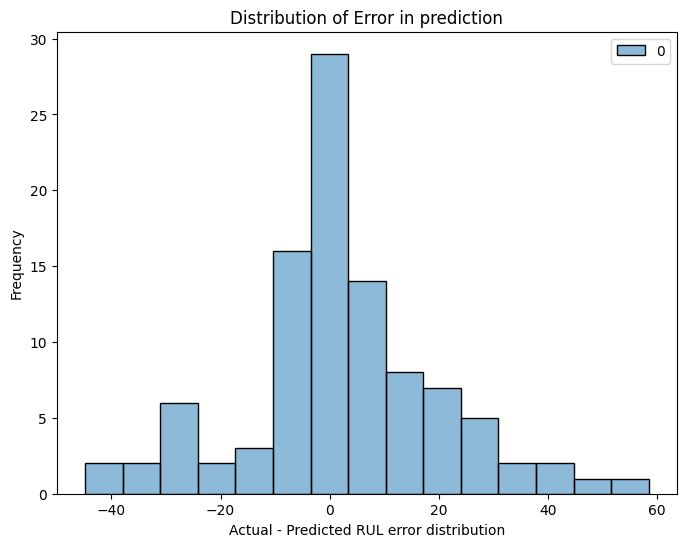

In [13]:
prediction_difference = np.array(rul_001 - RUL_predicted)
plt.figure(figsize=(8, 6))
sns.histplot(prediction_difference, bins=15)
plt.xlabel("Actual - Predicted RUL error distribution")
plt.ylabel("Frequency")
plt.title("Distribution of Error in prediction")
plt.show()

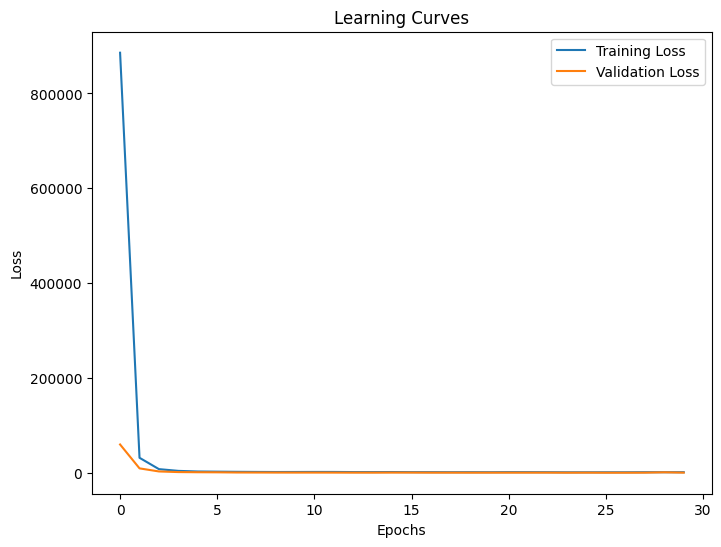

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

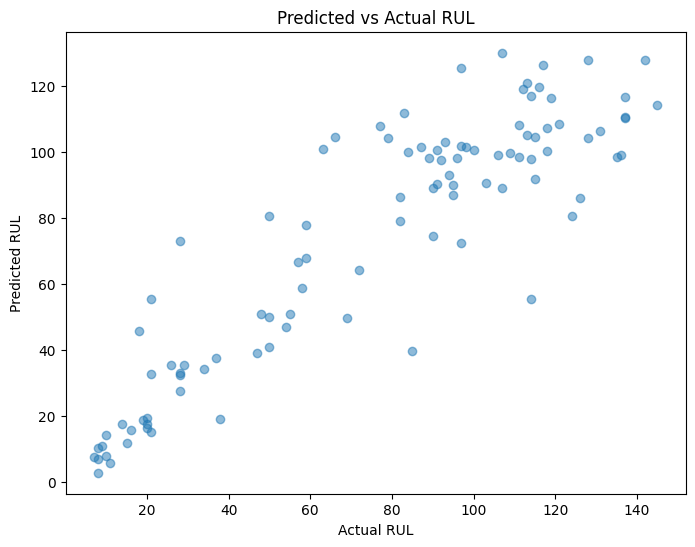

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(rul_001, RUL_predicted, alpha=0.5)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Predicted vs Actual RUL')
plt.show()

In [16]:
model.save('../items/window_10_model.h5')